In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rockcena@10042001',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/avish/OneDrive/Desktop/Pyhton&SQL Project/Dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

datab = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rockcena@10042001',
    database='ecommerce'
)

cur = datab.cursor()


#### List all unique cities where customers are located.

In [3]:
query = """SELECT DISTINCT CUSTOMER_CITY
        FROM ECOMMERCE.CUSTOMERS;"""

# query = """SELECT COUNT(DISTINCT CUSTOMER_CITY)
#         FROM ECOMMERCE.CUSTOMERS;"""
# Count of Cities = 4119

cur.execute(query)

data = cur.fetchall()

datfra = pd.DataFrame(data, columns = ['Customer_State'])
datfra.head(5)

,Customer_State
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#### Count the number of orders placed in 2017.

In [4]:
query = """SELECT COUNT(ORDER_ID) FROM ECOMMERCE.ORDERS
            WHERE YEAR(ORDER_PURCHASE_TIMESTAMP) = 2017;"""
cur.execute(query)

data = cur.fetchall()

data

[(180404,)]

#### Find the total sales per category.

In [6]:
query = """
        SELECT 
            UPPER(PRODUCTS.PRODUCT_CATEGORY) AS CATEGORY,
            ROUND(SUM(PAYMENTS.PAYMENT_VALUE), 2) AS SALES
        FROM
            PRODUCTS
                JOIN
            ORDER_ITEMS ON PRODUCTS.PRODUCT_ID = ORDER_ITEMS.PRODUCT_ID
                JOIN
            PAYMENTS ON PAYMENTS.ORDER_ID = ORDER_ITEMS.ORDER_ID
        GROUP BY CATEGORY;
"""
cur.execute(query)

data = cur.fetchall()

datfra = pd.DataFrame(data, columns = ["Category", "Sales"])

datfra

,Category,Sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,FASHION BAGS AND ACCESSORIES,1.396213e+07
4,BED TABLE BATH,1.096034e+08
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


#### Calculate the percentage of orders that were paid in installments.

In [7]:
query = """
       SELECT 
    SUM(CASE
        WHEN PAYMENT_INSTALLMENTS >= 1 THEN 1
        ELSE 0
    END) / COUNT(*) * 100
FROM
    PAYMENTS;
"""
cur.execute(query)

data = cur.fetchall()

'The percentage of orders that were paid in installments.',data[0][0]

('The percentage of orders that were paid in installments.',
 Decimal('99.9981'))

#### Count the number of customers from each state. 

<function matplotlib.pyplot.show(close=None, block=None)>

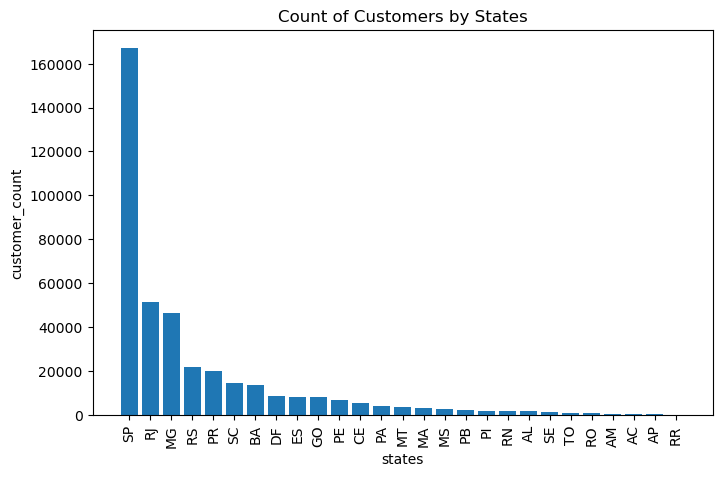

In [8]:
query = """
    SELECT 
    CUSTOMER_STATE, COUNT(CUSTOMER_ID) AS TOTAL_CUSTOMERS
FROM
    CUSTOMERS
GROUP BY CUSTOMER_STATE;
"""
cur.execute(query)

data = cur.fetchall()

datfra = pd.DataFrame(data, columns = ['Customer_State', 'Total_Customers'])
datfra = datfra.sort_values(by = 'Total_Customers', ascending= False)

plt.figure(figsize = (8,5))
plt.bar(datfra["Customer_State"],datfra["Total_Customers"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")

plt.show

#### Calculate the number of orders per month in 2018.

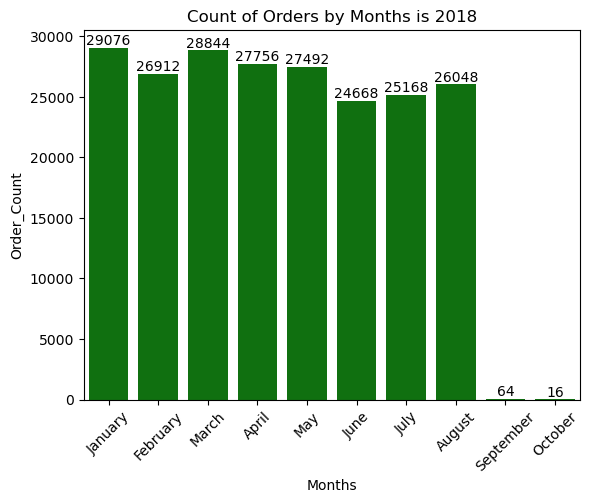

In [9]:
query = """
    SELECT 
    MONTHNAME(ORDER_PURCHASE_TIMESTAMP) AS MONTHS,
    COUNT(ORDER_ID) AS ORDER_COUNT
FROM
    ORDERS
WHERE
    YEAR(ORDER_PURCHASE_TIMESTAMP) = 2018
GROUP BY MONTHS;
"""
cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Months', 'Order_Count'])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["Months"],y =  df["Order_Count"], data = df, order = o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()


#### Find the average number of products per order, grouped by customer city.

In [10]:
query = """
    WITH Count_per_Order AS 
(SELECT 
    orders.order_id,
    orders.customer_id,
    COUNT(order_items.order_id) AS oc
FROM
    orders
        JOIN
    order_items ON orders.order_id = order_items.order_id
GROUP BY orders.order_id , orders.customer_id)

SELECT 
    customers.customer_city,
    ROUND(AVG(Count_per_Order.oc), 2) AS Average_Orders
FROM
    customers
        JOIN
    Count_per_Order ON customers.customer_id = Count_per_Order.customer_id
GROUP BY customers.customer_city;
"""
cur.execute(query)

data = cur.fetchall()
data

datfra = pd.DataFrame(data, columns = ["Customer_city","Average_Orders"])
datfra.head(10)

,Customer_city,Average_Orders
0,sao jose dos campos,18.22
1,indaial,17.85
2,treze tilias,20.36
3,sao paulo,18.50
4,rio de janeiro,18.35
5,mario campos,21.33
6,guariba,16.00
7,cuiaba,19.16
8,franca,20.03
9,tocos,16.00


#### Calculate the percentage of total revenue contributed by each product category.

In [13]:
query = """
   SELECT 
    UPPER(PRODUCTS.PRODUCT_CATEGORY) AS CATEGORY,
    ROUND((SUM(PAYMENTS.PAYMENT_VALUE)/(SELECT SUM(PAYMENT_VALUE) FROM PAYMENTS))*10, 1) AS SALES
FROM
    PRODUCTS
        JOIN
    ORDER_ITEMS ON PRODUCTS.PRODUCT_ID = ORDER_ITEMS.PRODUCT_ID
        JOIN
    PAYMENTS ON PAYMENTS.ORDER_ID = ORDER_ITEMS.ORDER_ID
GROUP BY CATEGORY
ORDER BY SALES DESC;
"""
cur.execute(query)

data = cur.fetchall()
data

datfra = pd.DataFrame(data, columns = ["Category","Sales %"])
datfra.head(10)

,Category,Sales %
0,BED TABLE BATH,17.1
1,HEALTH BEAUTY,16.6
2,COMPUTER ACCESSORIES,15.8
3,FURNITURE DECORATION,14.3
4,WATCHES PRESENT,14.3
5,SPORT LEISURE,13.9
6,HOUSEWARES,10.9
7,AUTOMOTIVE,8.5
8,GARDEN TOOLS,8.4
9,COOL STUFF,7.8


#### Identify the correlation between product price and the number of times a product has been purchased.

In [14]:
import numpy as np

query = """
   SELECT 
    products.product_category,
    COUNT(order_items.product_id),
    ROUND(AVG(order_items.price), 2)
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""
cur.execute(query)

data = cur.fetchall()

datfra = pd.DataFrame(data, columns = ["Category", "Order_Count", "Average_Price"])

arr1 = datfra["Order_Count"]
arr2 = datfra["Average_Price"]

a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][-1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


#### Calculate the total revenue generated by each seller, and rank them by revenue.


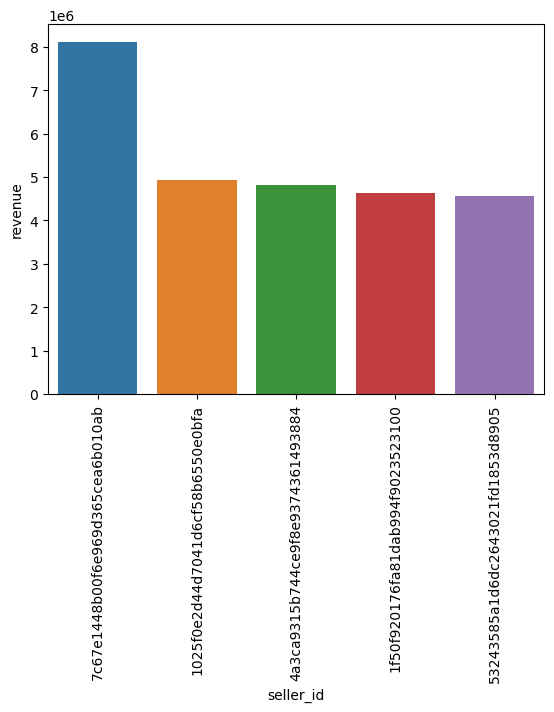

In [15]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

#### Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """ 
select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a """

cur.execute(query)
data = cur.fetchall()
data

datfra = pd.DataFrame(data , columns = ["Customer_Id","Time__Stamp","Payment","Moving_Average"])
datfra

,Customer_Id,Time__Stamp,Payment,Moving_Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
1662171,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662172,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662173,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
1662174,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


#### Calculate the cumulative sales per month for each year.

In [18]:
query = """ 
     select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a     
"""

cur.execute(query)
data = cur.fetchall()
data

datfra = pd.DataFrame(data, columns = ["Year", "Month","Payment","Cumulative_Sales"])
datfra

,Year,Month,Payment,Cumulative_Sales
0,2016,9,4035.84,4.035840e+03
1,2016,10,945447.68,9.494835e+05
2,2016,12,313.92,9.497974e+05
3,2017,1,2215808.64,3.165606e+06
4,2017,2,4670528.15,7.836134e+06
5,2017,3,7197817.59,1.503395e+07
6,2017,4,6684608.47,2.171856e+07
7,2017,5,9486701.12,3.120526e+07
8,2017,6,8180422.09,3.938568e+07
9,2017,7,9478126.71,4.886381e+07


#### Calculate the year-over-year growth rate of total sales.

In [19]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
datfra = pd.DataFrame(data, columns = ["years", "yoy % growth"])
datfra

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


#### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [20]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

#### Identify the top 3 customers who spent the most money in each year.

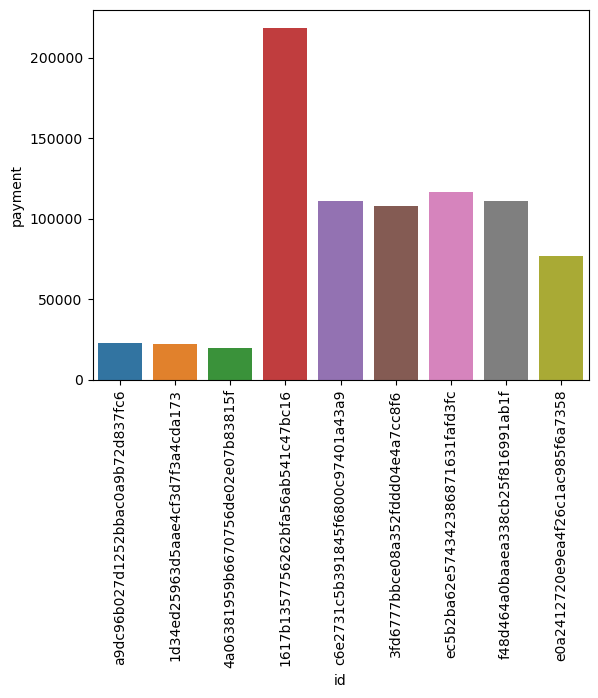

In [29]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
round(sum(payments.payment_value),2) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()


datfra = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = datfra)
plt.xticks(rotation = 90)
plt.show()